In [7]:
import pandas as pd
import torch
from PIL import Image
import urllib.request

from transformers import AutoProcessor, Blip2ForConditionalGeneration, AutoModelForSeq2SeqLM, AutoTokenizer

## Read data

In [8]:
path = 'data/preprocessed_wit_1_percent_20_langs.tsv'

In [9]:
df = pd.read_csv(path, sep='\t')
df

,Unnamed: 0,language,image_url,caption_reference_description,page_title,section_title
0,0,en,https://upload.wikimedia.org/wikipedia/commons...,Great Sleigh Drive (1678):Frederick William pu...,Brandenburg-Prussia,Dutch and Scanian Wars
1,1,en,http://upload.wikimedia.org/wikipedia/commons/...,G9 crew: Stoker Drake at extreme right of pict...,HMS G9,Loss
2,2,en,https://upload.wikimedia.org/wikipedia/commons...,Huichol woman and child,Huichol art,The Huichol People
3,3,en,https://upload.wikimedia.org/wikipedia/commons...,Merner-Pfeiffer Hall part of the Conservatory ...,Baldwin Wallace University,April Reign
4,4,en,https://upload.wikimedia.org/wikipedia/commons...,"1917 advertisement featuring Lloyd as ""Lonesom...",Harold Lloyd,Silent shorts and features
...,...,...,...,...,...,...
16795,16795,vi,https://upload.wikimedia.org/wikipedia/commons...,"Núi Sugarloaf, Rio de Janeiro được sử dụng cho...",The Amazing Race 2,Chặng 1 (Hoa Kỳ → Brasil)
16796,16796,vi,https://upload.wikimedia.org/wikipedia/commons...,Septic river.,Ô nhiễm biển,Nguồn xả trực tiếp
16797,16797,vi,https://upload.wikimedia.org/wikipedia/commons...,Phục nguyên P. grangeri,Platybelodon,Mô tả
16798,16798,vi,http://upload.wikimedia.org/wikipedia/commons/...,Một góc thành phố Huế bị tàn phá trơ trụi. Ảnh...,Sự kiện Tết Mậu Thân,Tại Huế


## Load BLIP-2 model

In [10]:
# setup device to use
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [11]:
# loads mBLIP pre-trained model
processor = AutoProcessor.from_pretrained('Gregor/mblip-mt0-xl')
model = Blip2ForConditionalGeneration.from_pretrained('Gregor/mblip-mt0-xl', torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
model.to(device)

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

## Translate the minimal prompt "On the picture:" into each of 19 languages

In [13]:
langs = set(df['language'])
print(sorted(langs))

['ar', 'ca', 'cs', 'de', 'en', 'es', 'fr', 'hu', 'it', 'iw', 'ja', 'nl', 'pl', 'pt', 'ru', 'sv', 'uk', 'vi', 'zh', 'zh-TW']


In [14]:
langs_encoded = {'ar': 'arb_Arab', 'ca': 'cat_Latn', 'cs': 'ces_Latn', 'de':'deu_Latn', 'es': 'spa_Latn', 'fr': 'fra_Latn',
                 'hu': 'hun_Latn', 'it': 'ita_Latn', 'iw': 'heb_Hebr', 'ja': 'jpn_Jpan', 'nl': 'nld_Latn', 'pl': 'pol_Latn',
                 'pt': 'por_Latn', 'ru': 'rus_Cyrl', 'sv': 'swe_Latn', 'uk': 'ukr_Cyrl', 'vi': 'vie_Latn', 'zh':'zho_Hans', 'zh-TW': 'zho_Hant'}

In [15]:
prompts = {'en':'On the picture:'}
prompt_en = prompts['en']

In [16]:
tokenizer_prompt = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model_prompt = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

In [17]:
inputs = tokenizer_prompt(prompt_en, return_tensors="pt")

In [18]:
for lang in langs_encoded:
    translated_tokens = model_prompt.generate(
    **inputs, forced_bos_token_id=tokenizer_prompt.convert_tokens_to_ids(langs_encoded[lang]), max_length=30
)
    prompts[lang] = tokenizer_prompt.batch_decode(translated_tokens, skip_special_tokens=True)[0]
prompts

{'en': 'On the picture:',
 'ar': 'على الصورة:',
 'ca': 'A la foto:',
 'cs': 'Na obrázku:',
 'de': 'Auf dem Bild:',
 'es': 'En la foto:',
 'fr': 'Sur la photo:',
 'hu': 'A képen:',
 'it': 'Sul quadro:',
 'iw': 'על התמונה:',
 'ja': '画像は:',
 'nl': 'Op de foto:',
 'pl': 'Na zdjęciu:',
 'pt': 'Na foto:',
 'ru': 'На картинке:',
 'sv': 'På bilden:',
 'uk': 'На фото:',
 'vi': 'Trên bức ảnh:',
 'zh': '在图片上:',
 'zh-TW': '這張照片:'}

## Run the model for the whole data

In [24]:
!pip install svglib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /Users/anitaguseinova/Library/Python/3.11/lib/python/site-packages/decord-0.6.0-py3.11-macosx-10.9-universal2.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 1.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 3.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 12.8 MB/s eta 0:00:00
  Created wheel for svglib: filename=svglib-1.5.1-py3-none-any.whl size=30910 sha256=9dfb3b8238351208d78b46f108233a6e6a93307d6b7a655db373496d573b49c8
  Stored in directory: /Users/anitaguseinova/Library/Caches/pip/wheels/7e/01/0e/e6e336915d6e8448890a695770ba88fe030cc71060988016f6


In [26]:
# Import svglib and reportlab
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM

# Convert SVG file to ReportLab Drawing object
drawing = svg2rlg("https://upload.wikimedia.org/wikipedia/commons/3/33/Capillary_microcirculation.svg")
print(type(drawing))
# Convert ReportLab Drawing object to PNG file
renderPM.drawToFile(drawing, "output.png", fmt="PNG")



Failed to load input file! (Error reading file 'https://upload.wikimedia.org/wikipedia/commons/3/33/Capillary_microcirculation.svg': failed to load external entity "https://upload.wikimedia.org/wikipedia/commons/3/33/Capillary_microcirculation.svg")


<class 'NoneType'>


AttributeError: 'NoneType' object has no attribute 'renderScale'

In [21]:
for lang in langs:
    df_lang = df[df['language'] == lang].reset_index()[:3]
    print(*[url for url in df_lang['image_url']])

    img_paths = [urllib.request.urlretrieve(img_url)[0] if not img_url.endswith('.svg') else 0 for img_url in df_lang['image_url']]
    images = [Image.open(img_path).convert('RGB') for img_path in img_paths]
    prompting = prompts[lang] * len(images)
    print(prompting)

    inputs = processor(images, text=prompting, return_tensors='pt').to(device, torch.float16)

    generated_ids = model.generate(**inputs, max_new_tokens=20)
    generated_text_en = processor.batch_decode(generated_ids, skip_special_tokens=True)
    print(generated_text_en)
    break

https://upload.wikimedia.org/wikipedia/commons/b/be/Zambezi_River_at_junction_of_Namibia%2C_Zambia%2C_Zimbabwe_%26_Botswana.jpg https://upload.wikimedia.org/wikipedia/commons/7/77/Braga_do_Monte_Picoto.jpg https://upload.wikimedia.org/wikipedia/commons/7/73/Switzerland_relief_location_map.jpg
Na foto:Na foto:Na foto:


KeyboardInterrupt: 

In [44]:
for idx, row in df.iterrows():
    print(row['language'])
    break

en


## Generate example for English

In [14]:
img_url_en = df['image_url'][0]

img_path_en, _ = urllib.request.urlretrieve(img_url_en, 'images/example_img.jpg')

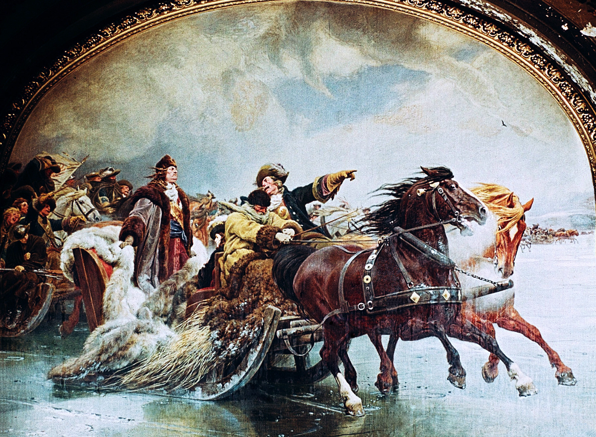

'Great Sleigh Drive (1678):Frederick William pursues Swedish troops across the frozen Curonian Lagoon; fresco by Wilhelm Simmler, ca. 1891'

In [15]:
# load sample image
image_en = Image.open(img_path_en).convert('RGB')
display(image_en.resize((596, 437)))
df['caption_reference_description'][0]

In [31]:
prompt = 'On the picture:'

inputs = processor(image_en, text=prompt, return_tensors='pt').to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text_en = processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text_en

198.06091976165771
['A painting of a man riding a horse and a woman riding a']
349.8132538795471


['A painting of a man riding a horse and a woman riding a',
 'A painting of a man riding a horse and a woman riding a',
 'A painting of a man riding a horse and a woman riding a']

## Generate example for German

In [17]:
df_de = df[df['language'] == 'de'].reset_index()
df_de

,index,Unnamed: 0,language,image_url,caption_reference_description
0,4023,4023,de,https://upload.wikimedia.org/wikipedia/commons...,Statue von Bernarda Morin in Santiago de Chile...
1,4024,4024,de,https://upload.wikimedia.org/wikipedia/commons...,John Singer Sargent: Porträt von William Merri...
2,4025,4025,de,https://upload.wikimedia.org/wikipedia/commons...,Die Porta Nigra in Trier ist eines der bekannt...
3,4026,4026,de,https://upload.wikimedia.org/wikipedia/commons...,Anne Haug – Siegerin 2017
4,4027,4027,de,http://upload.wikimedia.org/wikipedia/commons/...,Lage der Region in Alberta
...,...,...,...,...,...
4018,8041,8041,de,https://upload.wikimedia.org/wikipedia/commons...,Detailaufnahme Werk Neumünster
4019,8042,8042,de,https://upload.wikimedia.org/wikipedia/commons...,"Windkraftanlagen in Parnaíba, Piauí"
4020,8043,8043,de,https://upload.wikimedia.org/wikipedia/commons...,Logo des SR DRS bis 2007
4021,8044,8044,de,https://upload.wikimedia.org/wikipedia/commons...,Umriss und Querschnitt der fossilführenden Kar...


In [18]:
img_url_de = df_de['image_url'][0]

img_path_de, _ = urllib.request.urlretrieve(img_url_de, 'images/example_img_de.jpg')

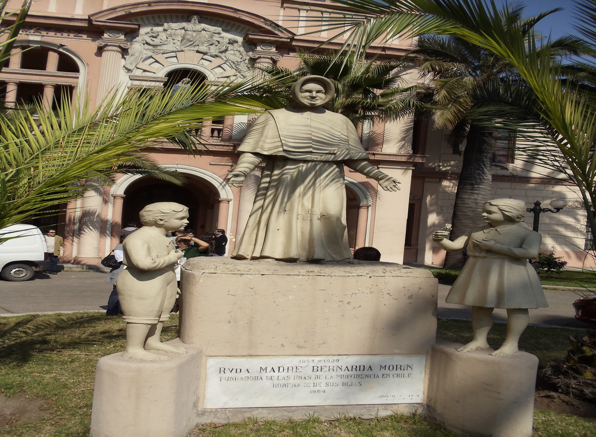

'Statue von Bernarda Morin in Santiago de Chile vor der Kirche ihrer Kongregation'

In [19]:
# load sample image
image_de = Image.open(img_path_de).convert('RGB')
display(image_de.resize((596, 437)))
df_de['caption_reference_description'][0]

In [21]:
prompt = 'Auf dem Bild:'

inputs = processor(image_de, text=prompt, return_tensors='pt').to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text_de = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
generated_text_de

Eine Statue steht vor einem Gebäude.


## Generate example for Russian

In [22]:
df_ru = df[df['language'] == 'ru'].reset_index()
df_ru

,index,Unnamed: 0,language,image_url,caption_reference_description
0,24138,24138,ru,https://upload.wikimedia.org/wikipedia/commons...,Дом на улице Кецховели в Баку (ныне улица имен...
1,24139,24139,ru,https://upload.wikimedia.org/wikipedia/commons...,Савиола празднует гол в составе «Бенфики»
2,24140,24140,ru,https://upload.wikimedia.org/wikipedia/commons...,Косой капонир
3,24141,24141,ru,https://upload.wikimedia.org/wikipedia/commons...,"Каменноостровский пр., 31-33."
4,24142,24142,ru,https://upload.wikimedia.org/wikipedia/commons...,Велогонка в 2018 году
...,...,...,...,...,...
4018,28156,28156,ru,https://upload.wikimedia.org/wikipedia/commons...,Герб
4019,28157,28157,ru,https://upload.wikimedia.org/wikipedia/commons...,Интерьер музея
4020,28158,28158,ru,https://upload.wikimedia.org/wikipedia/commons...,Расположение села (с/а) Акуаскиа
4021,28159,28159,ru,https://upload.wikimedia.org/wikipedia/commons...,Скелеты некоторых динозавров.\n1-й ряд (сверху...


In [23]:
img_url_ru = df_ru['image_url'][0]

img_path_ru, _ = urllib.request.urlretrieve(img_url_ru, 'images/example_img_ru.jpg')

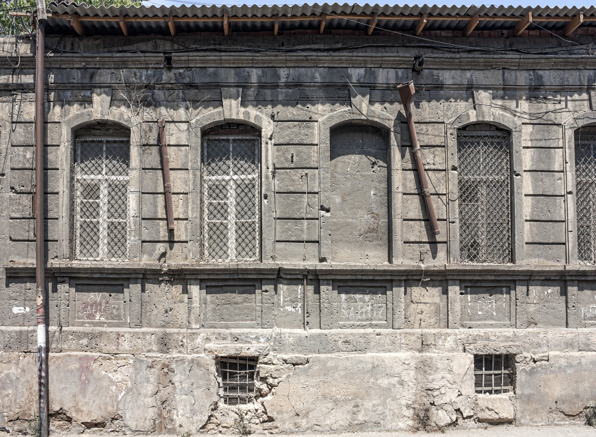

'Дом на улице Кецховели в Баку (ныне улица имени Академика Шамиля Азизбекова)'

In [27]:
# load sample image
image_ru = Image.open(img_path_ru).convert('RGB')
display(raw_image_ru.resize((596, 437)))
df_ru['caption_reference_description'][0]

In [28]:
prompt = 'На картинке:'

inputs = processor(image_ru, text=prompt, return_tensors='pt').to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text_ru = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
generated_text_ru

Человек, стоящий на улице рядом с зданием.


# Results Evaluation

In [29]:
from rouge_score import rouge_scorer

In [30]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [31]:
df_ru['caption_reference_description'][0]

'Дом на улице Кецховели в Баку (ныне улица имени Академика Шамиля Азизбекова)'

In [34]:
scores = scorer.score(df_ru['caption_reference_description'][0], generated_text_ru)
for key in scores:
    print(f'{key}: {scores[key]}')

rouge1: Score(precision=0.0, recall=0.0, fmeasure=0.0)
rouge2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
rougeL: Score(precision=0, recall=0, fmeasure=0)


In [35]:
type(processor)

transformers.models.blip_2.processing_blip_2.Blip2Processor